Mount Google Drive Videos

In [159]:
#! jupyter_notebook_config.py


In [160]:
from PIL import Image
import matplotlib.pyplot as plt 
import numpy as np
from sagemaker import get_execution_role
role=get_execution_role()
import sagemaker
import boto3 
import cv2
from io import BytesIO
from io import StringIO
import os
#sess = sagemaker.Session()
bucket = 'sagemakerfaizanmotiwala' # Set a default S3 bucket
s3 = boto3.client('s3')
subfolders='N2DL/Fluo-N2DL-HeLa - Training/02/'
contents=s3.list_objects(Bucket=bucket, Prefix=subfolders)['Contents']
#print(contents)
for f in contents:
    each_iter=f
    filename=each_iter['Key']
s3_resource = boto3.resource('s3')
s3_resource.meta.client.download_file(Bucket=bucket, Key=filename, Filename='/tmp/hello.tif')
h,w,d=cv2.imread('/tmp/hello.tif').shape
frames=len(contents)
path='/home/ec2-user/SageMaker/Processed_Train_02'
os.chdir(path)


#im = Image.open('/content/drive/MyDrive/CISdata/Training/01_ST/SEG/man_seg013.tif') #Dora's Path
#im = Image.open('s3://sagemakermotiwalafaizan/N2DL/Fluo-N2DL-HeLa - Training/01') #Fez's path
#im = Image.open('/content/drive/MyDrive/CIS519/01/t000.tif') #Dina's path
#plt.imshow(im)
#print(np.sort(im)


In [161]:
#bucket='sagemakerfaizanmotiwala'
#s3=boto3.client('s3')
#s3_resource = boto3.resource('s3')
#subfolders='processed/'
#contents=s3.list_objects(Bucket=bucket, Prefix=subfolders)['Contents']
#i=0
#s3_resource = boto3.resource('s3')
#for f in contents:
#    each_iter=f
#    filename=each_iter['Key']
#    s3_resource.meta.client.download_file(Bucket=bucket, Key=filename, Filename= path + str(i)+ '.tiff')

## **Preprocessing.**
Operations:

1.   Turn to Grayscale
2.   Threshold with Otsu
3.   Floodfill to fill gaps within cells
4.   Smoothen border with morphological operations

Output: A matrix with all preprocessed images

In [162]:
import cv2
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
import pylab
#from google.colab.patches import cv2_imshow

#image_folder = '/content/drive/MyDrive/CISdata/Testing/01' #Dora's path
#image_folder = '/content/drive/MyDrive/CIS 519/01' #Fez's path
#image_folder = '/content/drive/MyDrive/CIS519/01' #Dina's path
#im_names = [f for f in contents['Key']] #get the names
#im_names.sort()
#regex = re.compile('.*\).tif')
#im_names = [i for i in im_names if not regex.match(i)] #ordered and clean names
#check sizes of images
#h,w,d = cv2.imread(os.path.join(image_folder, im_names[0])).shape
#frames = len(contents)

mat_complete = np.zeros([h,w,frames])
mat_resized = np.zeros([h//10,w//10,frames])
i=0


for f in contents:
    each_iter=f
    filename=each_iter['Key']
    s3_resource.meta.client.download_file(Bucket=bucket, Key=filename, Filename='/tmp/hello.tif')
    fr=cv2.imread('/tmp/hello.tif',0)  # import+grayscale
    ret,thr = cv2.threshold(fr, 0, 255, cv2.THRESH_OTSU) # threshold

    im_fill = thr.copy()                                   # fills gaps in the cells
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(im_fill, mask, (0,0), 255)
    im_fill_inv = cv2.bitwise_not(im_fill)
    im_full = thr | im_fill_inv

    kernel = np.ones((7,7), np.uint8)                       # smoothens borders
    opening = cv2.morphologyEx(im_full, cv2.MORPH_CLOSE, kernel)

    mat_complete[:,:,i] = opening
    mat_resized[:,:,i] = cv2.resize(opening,(w//10,h//10))
    path='/home/ec2-user/SageMaker/Processed_Train_02'
    #cv2.imwrite(os.path.join(path, '0'+str(i) + '.tif'), mat_complete[:,:,i])

    img=Image.fromarray(mat_complete[:,:,i])
    out_img = BytesIO()
    img.save('/home/ec2-user/SageMaker/Processed_Train_02/' + str(i) + '.tif', format='tiff')
    #out_img.seek(0)
    #s3.put_object(Bucket= bucket, Key = 'processed/'+ str(i)+ '.tiff', Body = out_img, ContentType= 'image/png')  
    #cv2.imwrite(str(i)+'.tif', mat_complete[:,:,i])
    #print(f)
    i+=1
print('all_done')
#path='/home/ec2-user/SageMaker'
#os.chdir(path)
#!zip -r -X Processed.zip Processed

all_done


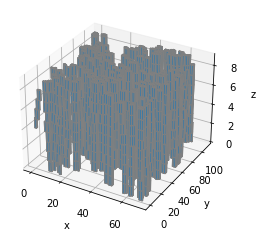

In [163]:
from mpl_toolkits.mplot3d import Axes3D

def make_ax(grid=False):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.grid(grid)
    return ax

ax = make_ax(True)
ax.voxels(mat_resized[:,:,1:10], edgecolors='gray', shade=False)
plt.show()


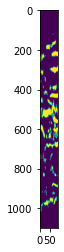

In [164]:
#https://www.datacamp.com/community/tutorials/matplotlib-3d-volumetric-data

def multi_slice_viewer(volume):
    remove_keymap_conflicts({'j', 'k'})
    fig, ax = plt.subplots()
    ax.volume = volume
    ax.index = volume.shape[0] // 2
    ax.imshow(volume[ax.index])
    fig.canvas.mpl_connect('key_press_event', process_key)

def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    if event.key == 'j':
        previous_slice(ax)
    elif event.key == 'k':
        next_slice(ax)
    fig.canvas.draw()

def previous_slice(ax):
    volume = ax.volume
    ax.index = (ax.index - 1) % volume.shape[0]  # wrap around using %
    ax.images[0].set_array(volume[ax.index])

def next_slice(ax):
    volume = ax.volume
    ax.index = (ax.index + 1) % volume.shape[0]
    ax.images[0].set_array(volume[ax.index])

def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

multi_slice_viewer(mat_complete)

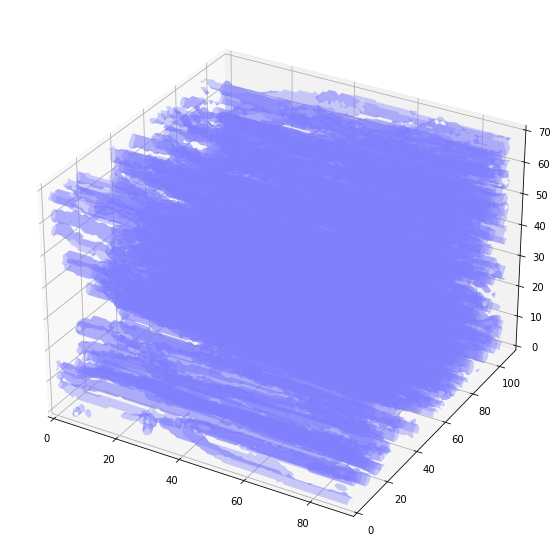

In [165]:
#https://stackoverflow.com/questions/56035562/3d-dicom-visualisation-in-python

from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
from skimage import measure

def plot_3d(image, threshold=0): 
    p = image.transpose(2,1,0)
    verts, faces, normals, values = measure.marching_cubes_lewiner(p, threshold)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(verts[faces], alpha=0.4)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)
    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

plot_3d(mat_resized)

In [166]:
#https://scipy-cookbook.readthedocs.io/items/vtkVolumeRendering.html


Code for Centroid Finding

In [167]:
#centroids=np.zeroes[,frames]  #I don't like this
import pandas as pd
first=0
img_n=0
img_g=0

global_x = []
global_y = []
global_n = []

for layer in range(frames): #all images 
  x = []
  y = []
  n = []
  first=mat_complete[:,:,layer] #select that layer
  img_n=cv2.normalize(src=first, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) #convert to 8unit
  contours, hierarchy= cv2.findContours(img_n, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) #find them contours
  cell_num = 0
  for c in contours: #iterate through all the blobs
    M=cv2.moments(c)
    if M["m00"]!=0:
        cX = int(M["m10"] / M["m00"]) #x coordinate
        cY = int(M["m01"] / M["m00"]) #y coordinate
    else:
        cX,cY=0,0
    center=(cX,cY) #centroid!!!!! 
    cell_num += 1
    x.append(cX)
    y.append(cY)
    n.append(cell_num)
  global_x.append(x)
  global_y.append(y)
  global_n.append(n)

print('all_done')

all_done


In [168]:
print(global_n)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 12

Code for Cell Tracking


all_done


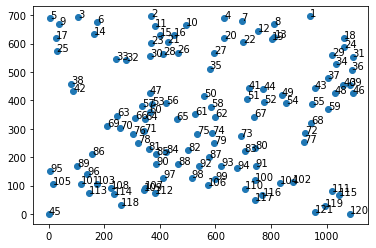

In [169]:

frame = 0

x = global_x[frame]
y = global_y[frame]
n = global_n[frame]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

print('all_done')


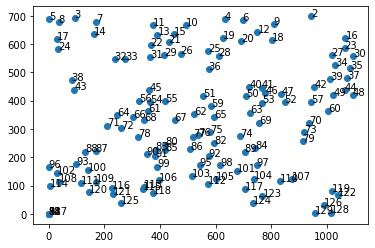

In [170]:
frame = 1

x = global_x[frame]
y = global_y[frame]
n = global_n[frame]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))



In [171]:
#Easiest way to annotate given that our cells seem to move very very slowly
#Try:
#Annotate by closest neighbor (from j to j+1)
#Anything unannotated treat like a new cell
#If two cells are 'close enough' to a mother cell, treat it as mitosis and rename cells entirely.

for f in range(0, frames-1):
  current = f
  next = f+1
  for cell_next in range(len(global_x[next])):
    x1 = global_x[next][cell_next]
    y1 = global_y[next][cell_next]
    n1 = global_n[next][cell_next]

    smallest_dist = 1000.0
    smallest_dist_n = n1
    smallest_dist_index = 0
    for cell in range(len(global_x[current])):
      x2 = global_x[current][cell]
      y2 = global_y[current][cell]
      n2 = global_n[current][cell]
      dist = ((x2 - x1)**2 + (y2 - y1)**2)** 0.5

      if dist <= smallest_dist:
        
        smallest_dist_n = n2
        smallest_dist = dist 
        #print("smallest dist:", smallest_dist)
        smallest_dist_index = cell_next
      #print(smallest_dist_index)
      global_n[next][smallest_dist_index] = smallest_dist_n

print('all_done')



all_done


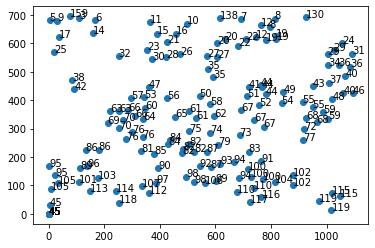

In [172]:
#can compare to above - we added a cell as expected
frame = 7

x = global_x[frame]
y = global_y[frame]
n = global_n[frame]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

In [173]:
#if there's a duplicate:
#if one is much closer to the parent cell, we assume the other came into view, and we relabel that one. 
#if they're both not that close to the original cell, we assume mitosis and relabel both. 

for f in range(0, frames-1):
  current = f
  next = f+1
  for cell_next in range(len(global_x[next])):
    x1 = global_x[next][cell_next]
    y1 = global_y[next][cell_next]
    n1 = global_n[next][cell_next]

    
    for cell_dup in range(len(global_x[next])):
      x2 = global_x[next][cell_dup]
      y2 = global_y[next][cell_dup]
      n2 = global_n[next][cell_dup]
      if (n1 == n2 and cell_next != cell_dup):
        
        print("I found a duplicate!")
        #print(cell_next)
        #print(cell_dup)
        print("n1", n1)
        print("n2", n2)
        # Find parent
        for cell in range(len(global_x[current])):
          x = global_x[current][cell]
          y = global_y[current][cell]
          n = global_n[current][cell]

          if n == n1:
            if (((x1 - x)**2 + (y1 - y)**2)** 0.5) < 5 and (((x2 - x)**2 + (y2 - y)**2)** 0.5) > 5:
              global_n[next][cell_dup] = max(global_n[next]) + 1
            elif (((x1 - x)**2 + (y1 - y)**2)** 0.5) > 5 and (((x2 - x)**2 + (y2 - y)**2)** 0.5) < 5:
              global_n[next][cell_next] = max(global_n[next]) + 1
            else:
              global_n[next][cell_next] = max(global_n[next]) + 1
              global_n[next][cell_dup] = max(global_n[next]) + 2







        




I found a duplicate!
n1 27
n2 27
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 44
n2 44
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 75
n2 75
I found a duplicate!
n1 84
n2 84
I found a duplicate!
n1 85
n2 85
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 105
n2 105
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 27
n2 27
I found a duplicate!
n1 27
n2 27
I found a duplicate!
n1 36
n2 36
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 44
n2 44
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 44
n2 44
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 75
n2 75
I found a duplicate!
n1 75
n2 75
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 85
n2 85
I found a duplicate!
n1 45
n2 45
I foun

n2 61
I found a duplicate!
n1 70
n2 70
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 84
n2 84
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 84
n2 84
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 87
n2 87
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 87
n2 87
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 104
n2 104
I found a duplicate!
n1 105
n2 105
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 110
n2 110
I found a duplicate!
n1 105
n2 105
I found a duplicate!
n1 115
n2 115
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a dupli

n2 22
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 29
n2 29
I found a duplicate!
n1 26
n2 26
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 29
n2 29
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 44
n2 44
I found a duplicate!
n1 50
n2 50
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 58
n2 58
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 64
n2 64
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 70
n2 70
I fo

n1 35
n2 35
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 44
n2 44
I found a duplicate!
n1 50
n2 50
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 58
n2 58
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 64
n2 64
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 70
n2 70
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 70
n2 70
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 84
n2 8

n2 35
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 50
n2 50
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 70
n2 70
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I fo

n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 50
n2 50
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I fo

n1 29
n2 29
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 12
n2 12
I found a duplicate!
n1 12
n2 12
I found a duplicate!
n1 12
n2 12
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 12
n2 12
I found a duplicate!
n1 12
n2 12
I found a duplicate!
n1 12
n2 12
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 26
n2 2

n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 50
n2 50
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 69
n2 69
I fo

n2 96
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 96
n2 96
I found a duplicate!
n1 103
n2 103
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 104
n2 104
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 101
n2 101
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 105
n2 105
I found a duplicate!
n1 116
n2 116
I found a duplicate!
n1 105
n2 105
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 119
n2 119
I found a d

I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 68
n2 68
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a 

n1 24
n2 24
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 29
n2 29
I found a duplicate!
n1 25
n2 25
I found a duplicate!
n1 26
n2 26
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 25
n2 25
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 4

n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 105
n2 105
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 115
n2 115
I found a duplicate!
n1 113
n2 113
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 101
n2 101
I found a duplicate!
n1 104
n2 104
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I

n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 44
n2 44
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 56
n2 56
I fo

n1 113
n2 113
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 115
n2 115
I found a duplicate!
n1 115
n2 115
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicat

n2 61
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 70
n2 70
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I fo

n1 14
n2 14
I found a duplicate!
n1 17
n2 17
I found a duplicate!
n1 29
n2 29
I found a duplicate!
n1 21
n2 21
I found a duplicate!
n1 26
n2 26
I found a duplicate!
n1 26
n2 26
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 29
n2 29
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 40
n2 40
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 44
n2 44
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 44
n2 44
I found a duplicate!
n1 40
n2 4

n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 5

n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 6

n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 42
n2 42
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 46
n2 46
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 57
n2 57
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 57
n2 57
I found a duplicate!
n1 53
n2 53
I fo

n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 84
n2 84
I found a duplicate!
n1 84
n2 84
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 7

I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a 

n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 85
n2 85
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I fo

I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 91
n2 91
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 103
n2 103
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!


n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 59
n2 5

n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 66
n2 66
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 84
n2 84
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 7

n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 93
n2 93
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 83
n2 83
I fo

n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 42
n2 42
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 50
n2 50
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 46
n2 46
I found a duplicate!
n1 57
n2 57
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 57
n2 57
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 5

n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 104
n2 104
I found a duplicate!
n1 104
n2 104
I found a duplicate!
n1 117
n2 117
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I f

n2 11
I found a duplicate!
n1 11
n2 11
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 205
n2 205
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 16
n2 16
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 15
n2 15
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I 

n2 100
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 103
n2 103
I found a duplicate!
n1 91
n2 91
I found a duplicate!
n1 104
n2 104
I found a duplicate!
n1 104
n2 104
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 101
n2 101
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100


n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I fo

n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 84
n2 84
I found a duplicate!
n1 77
n2 77
I found a duplicate!
n1 77
n2 77
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 77
n2 77
I found a duplicate!
n1 77
n2 77
I found a duplicate!
n1 77
n2 77
I found a duplicate!
n1 77
n2 77
I found a duplicate!
n1 94
n2 94
I fo

n2 76
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I fo

n1 55
n2 55
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 3

n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 84
n2 84
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 92
n2 92
I fo

n2 35
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 57
n2 57
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 57
n2 57
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I fo

I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 42
n2 42
I found a duplicate!
n1 42
n2 42
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a 

n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 230
n2 230
I found a duplicate!
n1 230
n2 230
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a

n1 94
n2 94
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 96
n2 96
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 87
n2 87
I found a duplicate!
n1 91
n2 91
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 103
n2 103
I found a duplicate!
n1 87
n2 87
I found a duplicate!
n1 100
n2 100
I fou

n2 59
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I fo

I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 15
n2 15
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 29
n2 29
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a 

n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100

n1 51
n2 51
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 46
n2 46
I found a duplicate!
n1 46
n2 46
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 66
n2 66
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 42
n2 42
I found a duplicate!
n1 59
n2 5

n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 205
n2 205
I found a duplicate!
n1 205
n2 205
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n

I found a duplicate!
n1 104
n2 104
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 113
n2 113
I found a duplicate!
n1 113
n2 113
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 1

n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 98
n2 98
I fo

n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 205
n2 205
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 205
n2 205
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 31
n2 31
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 15
n2 15
I found a duplicate!
n1 20
n2 20
I foun

n2 103
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 87
n2 87
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplic

n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 29
n2 29
I found a duplicate!
n1 31
n2 31
I found a duplicate!
n1 17
n2 17
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 25
n2 25
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 44
n2 44
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I fo

n2 105
I found a duplicate!
n1 105
n2 105
I found a duplicate!
n1 105
n2 105
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 113
n2 113
I found a duplicate!
n1 113
n2 113
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 105
n2 105
I found a duplicate!
n1 105
n2 105
I found a duplicate!
n1 105
n2 105
I found a duplicate!
n1 119
n2 119
I found a 

n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 55
n2 55
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 62
n2 62
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I fo

n2 23
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 44
n2 44
I found a duplicate!
n1 42
n2 42
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 44
n2 44
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 57
n2 57
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I fo

n2 105
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 117
n2 117
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate

I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 35
n2 35
I found a 

n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 205
n2 205
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I fo

n2 92
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 87
n2 87
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 91
n2 91
I found a duplicate!
n1 95
n2 95
I found a duplicate!


I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 56
n2 56
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 46
n2 46
I found a duplicate!
n1 46
n2 46
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 35
n2 35
I found a 

n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate

n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 7

n2 3
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 10
n2 10
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 11
n2 11
I found a duplicate!
n1 205
n2 205
I found a duplicate!
n1 10
n2 10
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 45
n2 45
I found a duplicate!


I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a 

n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 8
n2 8
I found a duplicate!
n1 10
n2 10
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 11
n2 11
I found a duplicate!
n1 205
n2 205
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 11
n2 11
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 3
n2 3
I found

n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 7

n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 4

n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 

n2 95
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 103
n2 103
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 95
n2 95
I found a dup

n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 51
n2 51
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 53
n2 53
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 4

n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1

n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 63
n2 63
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 65
n2 65
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 67
n2 67
I found a duplicate!
n1 67
n2 67
I fo

n1 20
n2 20
I found a duplicate!
n1 15
n2 15
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 29
n2 29
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 17
n2 17
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 2

n2 95
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 77
n2 77
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 77
n2 77
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 87
n2

n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 42
n2 42
I found a duplicate!
n1 42
n2 42
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 49
n2 49
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I fo

n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 115
n2 115
I found a duplicate!
n1 115
n2 115
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 110
n2 110
I found a duplicate!
n1 105
n2 105
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 113
n2 113
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n

n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 84
n2 84
I found a duplicate!
n1 84
n2 84
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 73
n2 73
I found a duplicate!
n1 73
n2 73
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 7

n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 15
n2 15
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1

I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1

n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 42
n2 42
I found a duplicate!
n1 42
n2 42
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 49
n2 4

n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplica

n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 60
n2 60
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 69
n2 69
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 5

n1 105
n2 105
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 113
n2 113
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 117
n2 117
I found a duplicate!
n1 117
n2 117
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I foun

n2 95
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 94
n2

n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 104
n2 104
I found a duplicate!
n1 117
n2 117
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45

n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 82
n2 8

n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 117
n2 117
I found a duplicate!
n1 117
n2 117
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 114
n2 114
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 119
n2 119
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 3
n

n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 73
n2 73
I found a duplicate!
n1 73
n2 73
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 45
n2 45
I fo

n1 3
n2 3
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 22
n2 22
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 3
n2 3
I found a duplicate!
n1 

n1 76
n2 76
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 95
n2 95
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 97
n2 97
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 98
n2 98
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 92
n2 92
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a duplicate!
n1 100
n2 100
I found a dup

n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 17
n2 17
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I fo

I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 73
n2 73
I found a duplicate!
n1 73
n2 73
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 73
n2 73
I found a duplicate!
n1 73
n2 73
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a 

I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 106
n2 106
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 7
n2 7
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I fo

n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 94
n2 94
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 79
n2 79
I fo

n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 20
I found a duplicate!
n1 20
n2 2

n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 45
n2 45
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 76
n2 76
I found a duplicate!
n1 73
n2 73
I found a duplicate!
n1 73
n2 73
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 61
n2 61
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 83
n2 83
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I found a duplicate!
n1 82
n2 82
I fo

n2 3
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 24
n2 24
I found a duplicate!
n1 17
n2 17
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 14
n2 14
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 32
n2 32
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 37
n2 37
I found a duplicate!
n1 34
n2 34
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 30
n2 30
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 23
n2 23
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 35
n2 35
I found a duplicate!
n1 34
n2 34
I fou

I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 59
n2 59
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 86
n2 86
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 54
n2 54
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 79
n2 79
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 102
n2 102
I found a duplicate!
n1 76
n2 76


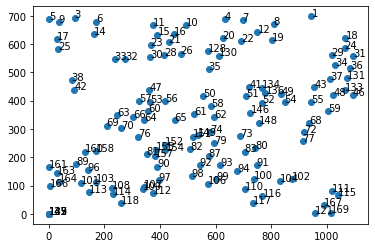

In [174]:
#Duplicate is added as a new cell, as expected.

frame = 1

x = global_x[frame]
y = global_y[frame]
n = global_n[frame]

fig, ax = plt.subplots()
ax.scatter(x, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i], y[i]))

In [175]:
# For each cell:
# For each frame:
# - direction
# - image
# This constitutes our training set. 

#Make a table to keep all this info. 

import pandas as pd
import itertools

global_n_master = np.unique(list(itertools.chain.from_iterable(global_n)))

cells_info = []

for c in global_n_master:
  frame_info = pd.DataFrame(columns=["Cell_Num", "Frame_Num", "Centroid", "Outline", "Direction"])
  #for f in range(frames):
  #for now: later go through all frames
  for f in range(frames):
    cell_num = c
    frame_num = f
    try:
      index = global_n[f].index(c)
    except ValueError:
      break

    centroid = (global_x[f][index], global_y[f][index])
    if f == 0:
      direction = [0,0]
    else:
      direction = np.subtract(centroid,frame_info["Centroid"][f-1])
    

    # Find contours
    first=mat_complete[:,:,f] #select that layer
    img_n=cv2.normalize(src=first, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U) #convert to 8unit
    contours, hierarchy= cv2.findContours(img_n, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) #find them contours
    ex_coord = (0,0,0,0)
    for contour in contours: #iterate through all the blobs
      #find extreme points of the countour
      #https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/
      extLeft = tuple(contour[contour[:, :, 0].argmin()][0])
      extRight = tuple(contour[contour[:, :, 0].argmax()][0])
      extTop = tuple(contour[contour[:, :, 1].argmin()][0])
      extBot = tuple(contour[contour[:, :, 1].argmax()][0])
      M=cv2.moments(contour)
      if M["m00"]!=0:
        cX = int(M["m10"] / M["m00"]) #x coordinate
        cY = int(M["m01"] / M["m00"]) #y coordinate
      else:
        cX,cY= 0,0
      center=(cX,cY) #centroid!!!!! 
      if (center == centroid):
        ex_coord = (extLeft[0], extRight[0], extTop[1], extBot[1])

    frame_info.loc[f] = [cell_num, frame_num, centroid, ex_coord, direction]

  cells_info.append(frame_info)

print('all_done')




all_done


In [176]:
print(cells_info[5])

   Cell_Num Frame_Num    Centroid               Outline Direction
0         6         0  (174, 676)  (166, 182, 665, 690)    [0, 0]
1         6         1  (171, 679)  (161, 181, 668, 693)   [-3, 3]
2         6         2  (170, 679)  (160, 181, 668, 694)   [-1, 0]
3         6         3  (170, 684)  (161, 181, 673, 699)    [0, 5]
4         6         4  (170, 685)  (160, 181, 674, 699)    [0, 1]
5         6         5  (169, 684)  (160, 180, 673, 699)  [-1, -1]
6         6         6  (166, 684)  (157, 177, 672, 699)   [-3, 0]
7         6         7  (168, 682)  (159, 179, 670, 699)   [2, -2]
8         6         8  (167, 684)  (158, 178, 672, 699)   [-1, 2]
9         6         9  (167, 686)  (157, 179, 675, 699)    [0, 2]
10        6        10  (167, 687)  (157, 180, 676, 699)    [0, 1]
11        6        11  (169, 686)  (159, 182, 675, 699)   [2, -1]
12        6        12  (168, 686)  (157, 181, 675, 699)   [-1, 0]
13        6        13  (172, 684)  (161, 185, 672, 699)   [4, -2]
14        

In [177]:
#DO NOT RUN TWICE
for c in range(len(cells_info)):
  cells_info[c]['Direction'] = cells_info[c].Direction.shift(-1)
  cells_info[c] = cells_info[c].dropna()


# This shifts it so that each column has direction cell is going in, instead of 
# where it came from. 
cells_info[5]

,Cell_Num,Frame_Num,Centroid,Outline,Direction
0,6,0,"(174, 676)","(166, 182, 665, 690)","[-3, 3]"
1,6,1,"(171, 679)","(161, 181, 668, 693)","[-1, 0]"
2,6,2,"(170, 679)","(160, 181, 668, 694)","[0, 5]"
3,6,3,"(170, 684)","(161, 181, 673, 699)","[0, 1]"
4,6,4,"(170, 685)","(160, 181, 674, 699)","[-1, -1]"
5,6,5,"(169, 684)","(160, 180, 673, 699)","[-3, 0]"
6,6,6,"(166, 684)","(157, 177, 672, 699)","[2, -2]"
7,6,7,"(168, 682)","(159, 179, 670, 699)","[-1, 2]"
8,6,8,"(167, 684)","(158, 178, 672, 699)","[0, 2]"
9,6,9,"(167, 686)","(157, 179, 675, 699)","[0, 1]"


In [178]:
cells_info_df = pd.concat(cells_info)

csv_buffer=StringIO()
cells_info_df.to_csv(csv_buffer)
content=csv_buffer.getvalue()
s3 = boto3.client('s3')
s3.put_object(Bucket=bucket, Body=content,Key='labels.csv')
print(cells_info)
path='/home/ec2-user/SageMaker/Processed_Train_02'
os.chdir(path)
cells_info_df.to_csv("labels.csv", index=False)
#id = 5

#direction = cells_info_df.iloc[id]["Direction"]
#crop_coord = cells_info_df.iloc[id]["Outline"]
#frame = cells_info_df.iloc[id]["Frame_Num"]

#left = crop_coord[0]
#right = crop_coord[1]
#top = crop_coord[2]
#bottom = crop_coord[3]

#print(left)
#print(right)
#print(top)
#print(bottom)

#img = mat_complete[:,:,frame][left:right, top:bottom]
#img_tensor = transforms.ToTensor()(img)
#img_tensor

[  Cell_Num Frame_Num    Centroid               Outline Direction
0        1         0  (941, 696)  (930, 951, 692, 699)    [3, 2], Empty DataFrame
Columns: [Cell_Num, Frame_Num, Centroid, Outline, Direction]
Index: [],   Cell_Num Frame_Num    Centroid              Outline  Direction
0        3         0  (106, 694)  (88, 121, 688, 699)  [-12, -1]
1        3         1   (94, 693)  (76, 110, 685, 699)    [0, -1]
2        3         2   (94, 692)  (76, 109, 683, 699)    [2, -4],   Cell_Num Frame_Num    Centroid               Outline Direction
0        4         0  (632, 689)  (613, 653, 678, 699)    [1, 0]
1        4         1  (633, 689)  (616, 654, 678, 699)   [-2, 0]
2        4         2  (631, 689)  (616, 651, 677, 699)   [-6, 3],   Cell_Num Frame_Num  Centroid            Outline Direction
0        5         0  (7, 689)  (0, 17, 676, 699)   [-4, 0]
1        5         1  (3, 689)   (0, 8, 677, 699)   [-1, 0]
2        5         2  (2, 689)   (0, 5, 678, 699)  [-1, -1]
3        5        

From here, we put the data into the CNN. 
